# Modelado de Clusterización para Segmentación de Sellers

**Objetivo:**  
Identificar grupos de vendedores con patrones similares que permitan diseñar estrategias comerciales diferenciadas.

**Fases (CRISP-DM adaptado):**
- Modelado  
- Evaluación  

**Preguntas guía:**
- ¿Qué variables son más relevantes para diferenciar tipos de sellers?
- ¿Cuántos clusters son razonables desde el punto de vista técnico y de negocio?
- ¿Qué características definen a cada cluster?
- ¿Cómo podrían usarse estos segmentos en la práctica (priorización, campañas, incentivos, etc.)?


In [11]:
import pandas as pd
import numpy as np
df_seller = pd.read_csv("../datos/procesado/data_seller.csv")

In [12]:
df_seller.head()

,seller_nickname,num_items,categorias_unicas,categoria_moda,precio_mediano,precio_promedio,stock_total,stock_promedio,precio_log_medio,stock_log_medio,...,pct_used,pct_ne,pct_refurbished,DS,FBM,FLEX,Otro,XD,entropia_categorias,pct_categoria_moda
0,000631669c,1,1,OTROS,799.0,799.0,10,10.0,6.684612,2.397895,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.000000,1.0
1,0007153bca,2,1,OTROS,399.0,399.0,55,27.5,5.991465,3.348517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.000000,1.0
2,000bee3c3b,2,1,"LIBROS, MULTIMEDIA Y OTROS",382.5,382.5,0,0.0,5.761745,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.000000,1.0
3,000df2bd02,1,1,ACCESORIOS PARA AUTOS Y CAMIONETAS,1550.0,1550.0,5,5.0,7.346655,1.791759,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.000000,1.0
4,000e27cea2,2,2,ARTÍCULOS DEL HOGAR,457.5,457.5,6,3.0,6.060845,1.354025,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.693147,0.5


In [13]:
df_seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43308 entries, 0 to 43307
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   seller_nickname      43308 non-null  object 
 1   num_items            43308 non-null  int64  
 2   categorias_unicas    43308 non-null  int64  
 3   categoria_moda       43308 non-null  object 
 4   precio_mediano       43308 non-null  float64
 5   precio_promedio      43308 non-null  float64
 6   stock_total          43308 non-null  int64  
 7   stock_promedio       43308 non-null  float64
 8   precio_log_medio     43308 non-null  float64
 9   stock_log_medio      43308 non-null  float64
 10  pct_descuento_prom   43308 non-null  float64
 11  pct_con_descuento    43308 non-null  float64
 12  seller_reputation    43308 non-null  object 
 13  pct_new              43308 non-null  float64
 14  pct_used             43308 non-null  float64
 15  pct_ne               43308 non-null 

In [14]:
# Mapa ordinal de reputación de seller (0 = peor, 8 = mejor)
rep_order = {
    'newbie': 0,
    'red': 1,
    'orange': 2,
    'yellow': 3,
    'light_green': 4,
    'green': 5,
    'green_silver': 6,
    'green_gold': 7,
    'green_platinum': 8
}
# Crear columna numérica
df_seller['seller_rep_score'] = df_seller['seller_reputation'].map(rep_order)

# Verificar distribución del score
df_seller['seller_rep_score'].value_counts().sort_index()


seller_rep_score
0     6093
1     2040
2     1143
3     2571
4     1256
5    12802
6     6340
7     5317
8     5746
Name: count, dtype: int64

- La variable seller_reputation es categórica pero tiene un orden natural. Para usarla en el modelo de clustering se convierte en un score ordinal (seller_rep_score) con valores entre 0 y 8, donde 0 representa Newbie y 8 Green Platinum. Esto permite incorporar la reputación en el espacio numérico sin inflar dimensionalidad mediante dummies.

In [15]:
df_seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43308 entries, 0 to 43307
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   seller_nickname      43308 non-null  object 
 1   num_items            43308 non-null  int64  
 2   categorias_unicas    43308 non-null  int64  
 3   categoria_moda       43308 non-null  object 
 4   precio_mediano       43308 non-null  float64
 5   precio_promedio      43308 non-null  float64
 6   stock_total          43308 non-null  int64  
 7   stock_promedio       43308 non-null  float64
 8   precio_log_medio     43308 non-null  float64
 9   stock_log_medio      43308 non-null  float64
 10  pct_descuento_prom   43308 non-null  float64
 11  pct_con_descuento    43308 non-null  float64
 12  seller_reputation    43308 non-null  object 
 13  pct_new              43308 non-null  float64
 14  pct_used             43308 non-null  float64
 15  pct_ne               43308 non-null 

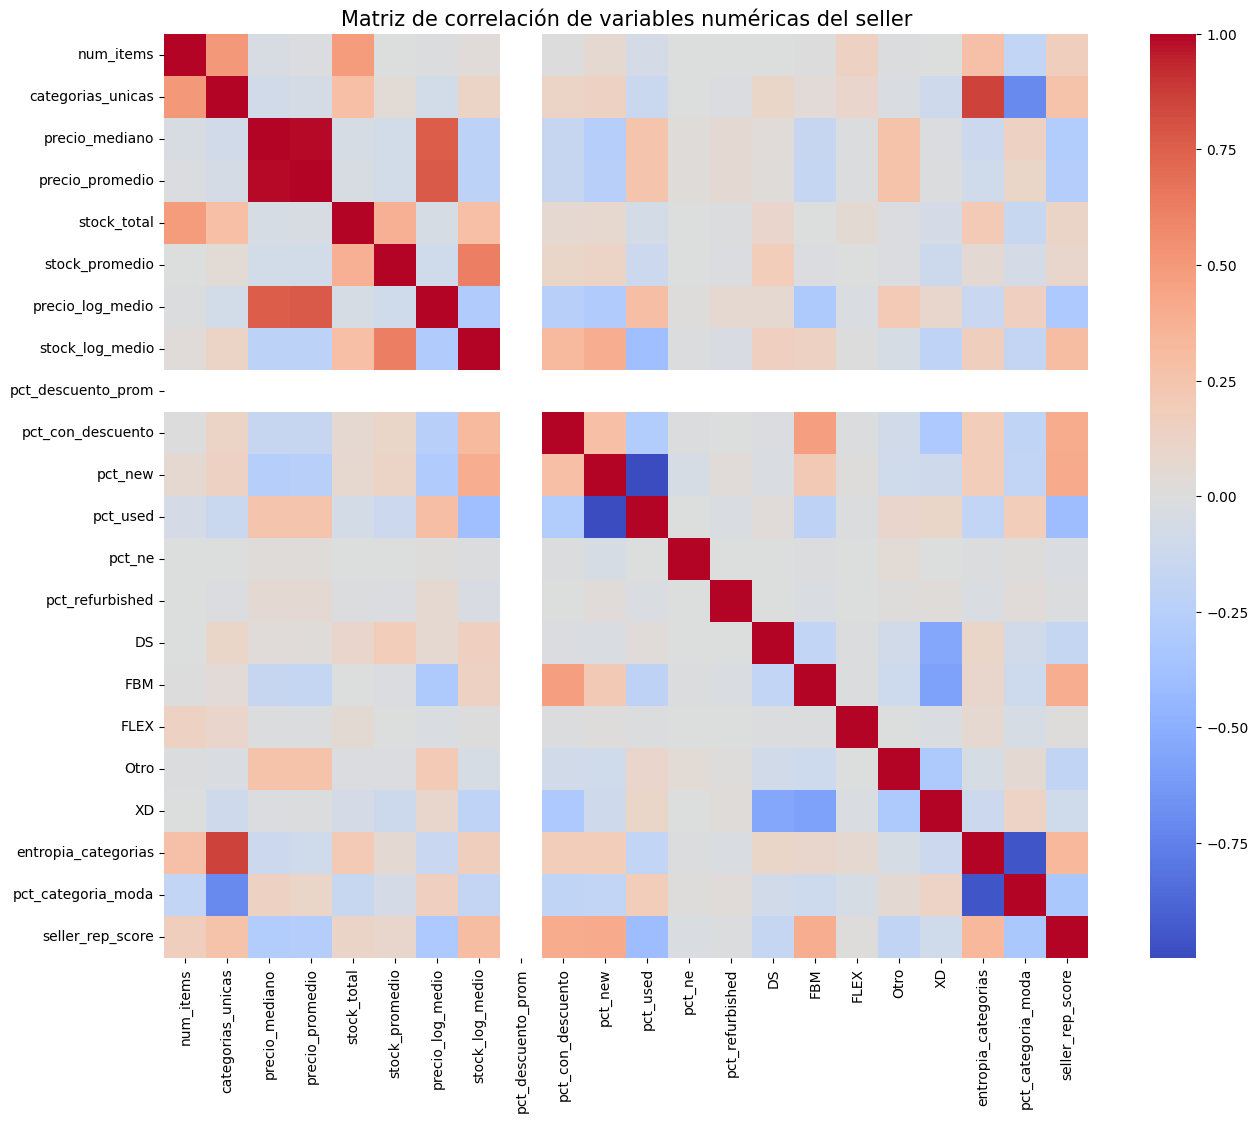

In [16]:
# Matriz de correlación
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar solo columnas numéricas del set de features
numeric_cols = df_seller.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(16, 12))
corr = numeric_cols.corr()

sns.heatmap(
    corr, 
    cmap="coolwarm", 
    center=0, 
    annot=False,
    square=True
)

plt.title("Matriz de correlación de variables numéricas del seller", fontsize=15)
plt.show()


In [18]:
# Quitamos las variables más correlacionadas
features = [
    'num_items',
    'categorias_unicas',

    # Versión log limpia, mejor que promedios crudos
    'precio_log_medio',
    'stock_log_medio',

    'pct_descuento_prom',
    'pct_con_descuento',

    'pct_new',
    'pct_used',
    'pct_ne',
    'pct_refurbished',

    'DS', 'FLEX', 'FBM', 'Otro', 'XD',

    'entropia_categorias',
    'pct_categoria_moda',

    'seller_rep_score'
]


In [19]:
# Escalamos los datos, como tenemos colas largas usamos roust scaler y no standar scaler
from sklearn.preprocessing import RobustScaler

# Crear scaler
scaler = RobustScaler()

# Ajustar y transformar
X_scaled = scaler.fit_transform(df_seller[features])

# Convertir a DataFrame para facilitar inspección
X_scaled = pd.DataFrame(X_scaled, columns=features)

X_scaled.head()


,num_items,categorias_unicas,precio_log_medio,stock_log_medio,pct_descuento_prom,pct_con_descuento,pct_new,pct_used,pct_ne,pct_refurbished,DS,FLEX,FBM,Otro,XD,entropia_categorias,pct_categoria_moda,seller_rep_score
0,0.0,0.0,0.237278,0.161230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-0.000000,0.00,-1.25
1,0.5,0.0,-0.223838,0.500331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,0.00,0.00
2,0.5,0.0,-0.376660,-0.694135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,0.00,-1.25
3,0.0,0.0,0.677703,-0.054988,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,0.00,0.00
4,0.5,1.0,-0.177683,-0.211134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,-0.5,1.088974,-1.75,0.25


In [20]:
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
num_items,43308.0,1.539485,7.237683,0.000000,0.000000,0.0,1.000000,679.000000
categorias_unicas,43308.0,0.736654,1.875359,0.000000,0.000000,0.0,1.000000,47.000000
precio_log_medio,43308.0,0.104693,0.783794,-2.645411,-0.431983,0.0,0.568017,2.540284
stock_log_medio,43308.0,0.162212,0.622912,-0.694135,-0.446879,0.0,0.553121,2.346633
pct_descuento_prom,43308.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
pct_con_descuento,43308.0,0.462190,0.724604,0.000000,0.000000,0.0,1.000000,1.750000
pct_new,43308.0,-0.169390,0.371096,-1.000000,0.000000,0.0,0.000000,0.000000
pct_used,43308.0,0.168936,0.370705,0.000000,0.000000,0.0,0.000000,1.000000
pct_ne,43308.0,0.000455,0.019176,0.000000,0.000000,0.0,0.000000,1.000000
pct_refurbished,43308.0,0.005607,0.070200,0.000000,0.000000,0.0,0.000000,1.000000


In [25]:
# ya que se usaraá un algoritmo de clasificación no supervisada se debe seleccionar correctamente el numero de clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = {}
inertias = {}

K = range(2, 11)  # probamos entre 2 y 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=13, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil
    inertias[k] = kmeans.inertia_

sil_scores, inertias


({2: 0.981906243186004,
  3: 0.9219937292354292,
  4: 0.7643645810262145,
  5: 0.6709916498961824,
  6: 0.4678441249139517,
  7: 0.3493896879108699,
  8: 0.34940119076024834,
  9: 0.3334759549295402,
  10: 0.34889812334985476},
 {2: 1538390.1268475214,
  3: 981141.086063863,
  4: 681308.3923349,
  5: 520581.5365525394,
  6: 421184.2914154627,
  7: 364417.56742941425,
  8: 311451.87816140486,
  9: 279728.74632402125,
  10: 253345.73328197532})

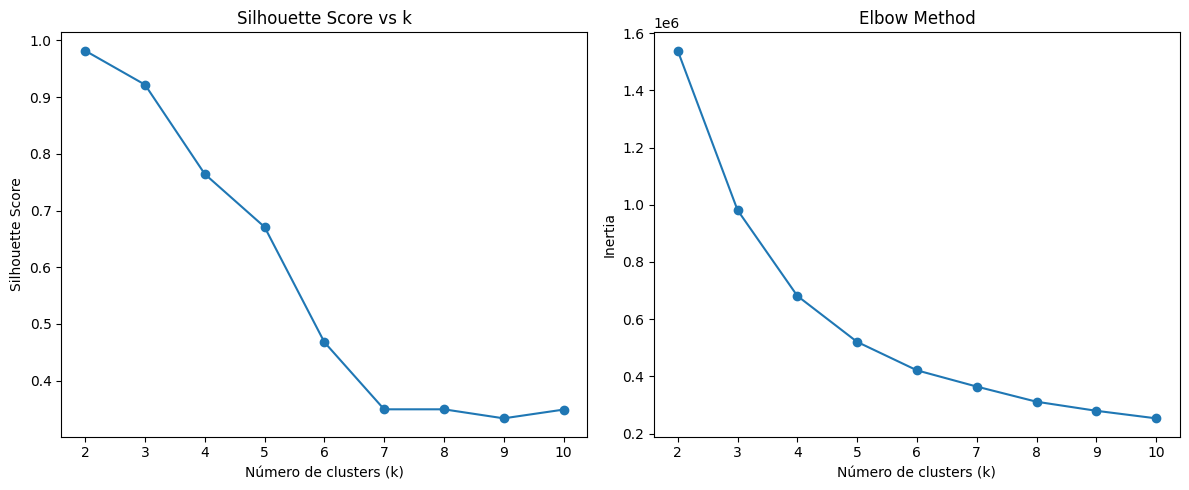

In [26]:
plt.figure(figsize=(12,5))

# Silhouette
plt.subplot(1,2,1)
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")

# Elbow
plt.subplot(1,2,2)
plt.plot(list(inertias.keys()), list(inertias.values()), marker='o')
plt.title("Elbow Method")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inertia")

plt.tight_layout()
plt.show()


- Se evaluaron distintos valores de k entre 2 y 10 utilizando Silhouette Score y Elbow Method. El mayor Silhouette Score ocurrió en k=2, pero se descartó por producir una segmentación excesivamente general. El elbow mostró quiebres en k=3 y k=4. Finalmente se seleccionó k = 4, al ofrecer un equilibrio entre calidad de segmentación (Silhouette ≈ 0.75) e interpretabilidad de negocio.

In [35]:
# Entrenamiento de modelo final
kmeans = KMeans(n_clusters=4, random_state=13, n_init=20)
df_seller['cluster'] = kmeans.fit_predict(X_scaled)


In [36]:
df_seller['cluster'].value_counts().sort_index()

cluster
0     1574
1        4
2    41642
3       88
Name: count, dtype: int64

In [39]:
cluster_profile = df_seller.groupby('cluster')[features].mean().round(1)
cluster_profile

,num_items,categorias_unicas,precio_log_medio,stock_log_medio,pct_descuento_prom,pct_con_descuento,pct_new,pct_used,pct_ne,pct_refurbished,DS,FLEX,FBM,Otro,XD,entropia_categorias,pct_categoria_moda,seller_rep_score
cluster,,,,,,,,,,,,,,,,,,
0,30.7,6.7,6.4,2.7,0.0,0.3,1.0,0.0,0.0,0.0,0.2,0.0,0.2,0.1,0.6,1.2,0.6,6.9
1,963.5,23.2,6.6,3.5,0.0,0.1,1.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.5,1.9,0.5,8.0
2,2.6,1.5,6.5,2.4,0.0,0.3,0.8,0.2,0.0,0.0,0.1,0.0,0.2,0.1,0.6,0.2,0.9,4.6
3,173.7,13.4,6.5,2.4,0.0,0.1,1.0,0.0,0.0,0.0,0.1,0.1,0.2,0.0,0.6,1.5,0.6,7.2


In [38]:
df_seller.groupby('cluster')['seller_rep_score'].mean().round(3)

cluster
0    6.949
1    8.000
2    4.579
3    7.250
Name: seller_rep_score, dtype: float64

In [40]:
pd.DataFrame(kmeans.cluster_centers_, columns=features)

,num_items,categorias_unicas,precio_log_medio,stock_log_medio,pct_descuento_prom,pct_con_descuento,pct_new,pct_used,pct_ne,pct_refurbished,DS,FLEX,FBM,Otro,XD,entropia_categorias,pct_categoria_moda,seller_rep_score
0,14.850064,5.695044,0.058764,0.268799,0.0,0.548231,-0.029707,0.029452,0.000255,0.001730,0.177027,0.002575,0.153194,0.053165,-0.385961,1.905985,-1.453764,0.487135
1,481.250000,22.250000,0.191011,0.549654,0.0,0.193764,0.000000,0.000000,0.000000,0.000184,0.237571,0.000000,0.250000,0.020734,-0.508305,2.910056,-1.861697,0.750000
2,0.811044,0.522501,0.106453,0.158142,0.0,0.459541,-0.175044,0.174581,0.000463,0.005763,0.134024,0.000024,0.168051,0.053700,-0.355799,0.391866,-0.462893,-0.105164
3,86.357955,12.409091,0.089509,0.163830,0.0,0.188789,-0.000052,0.000052,0.000000,0.001397,0.084127,0.125000,0.173188,0.023384,-0.405699,2.299188,-1.550673,0.562500


In [41]:
kmeans3 = KMeans(n_clusters=3, random_state=13, n_init=20)
df_seller['cluster3'] = kmeans3.fit_predict(X_scaled)
df_seller['cluster3'].value_counts()


cluster3
0    43079
1      225
2        4
Name: count, dtype: int64

### Nuevo intento

In [42]:
p99_items = df_seller['num_items'].quantile(0.99)
p99_stock = df_seller['stock_total'].quantile(0.99)

p99_items, p99_stock


(np.float64(39.0), np.float64(7655.720000000001))

In [43]:
mask_extremos = (df_seller['num_items'] > p99_items) | \
                (df_seller['stock_total'] > p99_stock)

df_seller[mask_extremos].shape


(785, 27)

In [44]:
df_seller_limpio = df_seller[~mask_extremos].copy()
df_seller_limpio.shape


(42523, 27)

In [45]:
from sklearn.cluster import KMeans

X = df_seller_limpio[features]
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
df_seller_limpio['cluster'] = kmeans.fit_predict(X_scaled)

df_seller_limpio['cluster'].value_counts().sort_index()
from sklearn.cluster import KMeans

X = df_seller_limpio[features]
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
df_seller_limpio['cluster'] = kmeans.fit_predict(X_scaled)

df_seller_limpio['cluster'].value_counts().sort_index()


cluster
0    29394
1    10594
2     1015
3     1520
Name: count, dtype: int64

In [46]:
cluster_profile = df_seller_limpio.groupby('cluster')[features].mean().round(2)
cluster_profile


,num_items,categorias_unicas,precio_log_medio,stock_log_medio,pct_descuento_prom,pct_con_descuento,pct_new,pct_used,pct_ne,pct_refurbished,DS,FLEX,FBM,Otro,XD,entropia_categorias,pct_categoria_moda,seller_rep_score
cluster,,,,,,,,,,,,,,,,,,
0,1.54,1.00,6.61,2.22,0.0,0.21,0.78,0.22,0.0,0.01,0.13,0.0,0.14,0.06,0.67,0.00,1.00,3.98
1,4.17,2.62,6.18,2.74,0.0,0.38,0.93,0.07,0.0,0.00,0.14,0.0,0.24,0.03,0.59,0.84,0.54,5.90
2,15.54,8.55,6.19,3.08,0.0,0.44,0.99,0.01,0.0,0.00,0.32,0.0,0.17,0.05,0.46,1.92,0.29,6.70
3,18.49,2.48,6.42,2.16,0.0,0.26,0.92,0.08,0.0,0.00,0.04,0.0,0.16,0.04,0.76,0.46,0.83,6.90


In [49]:
cluster_profile.shape

(4, 18)

- **Evaluación de la calidad y utilidad de los clusters (versión corta y técnica)**

El modelo generó 4 clusters con una distribución altamente asimétrica:
C0 = 29,394 sellers (≈67%), C1 = 10,594 (≈24%), C2 = 1,015 (≈2%) y C3 = 1,520 (≈3%). Este desbalance es esperable en marketplaces, pero debe considerarse para evitar que C0 domine análisis posteriores.

Las variables estructurales num_items y categorias_unicas explican gran parte de la separación:
C0 (1.5 ítems, 1 categoría) → C1 (4 ítems, 2.6 categorías) → C2 (15 ítems, 8.5 categorías) → C3 (18 ítems, 2.5 categorías). Esto muestra un gradiente claro entre sellers pequeños, medianos, diversificados y especializados.

La diferencia en seller_rep_score (C0 = 3.98 → C3 = 6.90) confirma que los clusters ordenan consistentemente los niveles de profesionalización. Lo mismo ocurre con la calidad de metadata: pct_ne cae de 0.21 (C0) a casi 0 en C2 y C3; y pct_new sube de 0.78 a 0.99 en C2.

Las modalidades logísticas también segmentan bien: C2 usa más DS (0.32), mientras C3 concentra XD (0.76), lo que indica estrategias operativas distintas.

En conjunto, los clusters muestran baja superposición, diferencias claras en catálogo, diversificación, reputación y logística, y una estructura coherente con comportamientos reales del marketplace.

Limitaciones: desbalance marcado, ausencia de variables de desempeño económico y la naturaleza lineal de KMeans, que puede no capturar separaciones no convexas. Aun así, el modelo es sólido como segmentación estructural inicial.

In [51]:
df_seller_limpio.head()

,seller_nickname,num_items,categorias_unicas,categoria_moda,precio_mediano,precio_promedio,stock_total,stock_promedio,precio_log_medio,stock_log_medio,...,DS,FBM,FLEX,Otro,XD,entropia_categorias,pct_categoria_moda,seller_rep_score,cluster,cluster3
0,000631669c,1,1,OTROS,799.0,799.0,10,10.0,6.684612,2.397895,...,0.0,0.0,0.0,1.0,0.0,-0.000000,1.0,0,0,0
1,0007153bca,2,1,OTROS,399.0,399.0,55,27.5,5.991465,3.348517,...,0.0,0.0,0.0,0.0,1.0,-0.000000,1.0,5,0,0
2,000bee3c3b,2,1,"LIBROS, MULTIMEDIA Y OTROS",382.5,382.5,0,0.0,5.761745,0.000000,...,0.0,0.0,0.0,0.0,1.0,-0.000000,1.0,0,0,0
3,000df2bd02,1,1,ACCESORIOS PARA AUTOS Y CAMIONETAS,1550.0,1550.0,5,5.0,7.346655,1.791759,...,0.0,0.0,0.0,0.0,1.0,-0.000000,1.0,5,0,0
4,000e27cea2,2,2,ARTÍCULOS DEL HOGAR,457.5,457.5,6,3.0,6.060845,1.354025,...,0.0,0.5,0.0,0.0,0.5,0.693147,0.5,6,1,0


In [52]:
df_seller_limpio.to_csv("../datos/procesado/sellers_clustered.csv", index=False)

In [53]:
cluster_profile.to_csv("../datos/procesado/cluster_profile.csv", index=False)

In [54]:
import joblib

joblib.dump(scaler, "../modelos/scaler_robust.pkl")
joblib.dump(kmeans, "../modelos/kmeans_sellers_k4.pkl")


['../modelos/kmeans_sellers_k4.pkl']